# This notebook serves as a testbed for the ABSA pipeline before we actually create scripts and a working pipeline.

Code implementation can be found in absa_model.py.
Example usage can be found in test.ipynb

In [1]:
# !python -m spacy download en_core_web_sm

## Load data and clean

In [1]:
import pandas as pd 

post_data = pd.read_csv('../data/posts_sentiment.csv')
post_data.shape

(448, 11)

In [2]:
post_data.head(5)

,Unnamed: 0,id,date,title,content,username,commentCount,score,subreddit,Code,sentiment
0,0,absdf,2019-08-03 11:27:29,中国产C919飞机有一大缺点 难获国际市场,中国C919飞机原定于去年年底交付。虽然在今年5月完成了即将交付用户的首架飞机的试飞，但还没...,xl,0,0,SouthwestAirlines,WN,NEUTRAL
1,1,1g7qgpv,2024-10-20 12:04:51,Question/Help,"Hey everyone, I know it’s a long shot, but I t...",Kmelloww,4,0,SouthwestAirlines,WN,NEGATIVE
2,2,1g7plv5,2024-10-20 11:12:20,Airpods left on plane,I left my airpods on a recent flight and I can...,Ph4Nt0M218,6,3,SouthwestAirlines,WN,NEGATIVE
3,4,1g7o4ce,2024-10-20 09:44:42,"If I book 4 tickets together and I’m A-List, w...",I know all the tickets in my booking get my bo...,DoubleJob6790,3,3,SouthwestAirlines,WN,NEUTRAL
4,5,1g7nqmh,2024-10-20 09:23:06,"Elliott, Southwest Airlines to begin settlemen...",Interesting,Even-Compote2602,9,20,SouthwestAirlines,WN,POSITIVE


In [ ]:
# Filtering non-english posts
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

DetectorFactory.seed = 42

def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

In [4]:
# Preprocessing text
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    # convert to lowercase
    text = text.lower()
    # remove numbers
    text = re.sub(r'\d+', '', text)
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # remove whitespaces and stemming
    # text = ' '.join([word for word in text.split() if word not in stop_words])
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])

    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
test_data = post_data[post_data['content'].apply(is_english)]
# combine title with content
test_data['content'] = test_data['title'] + ' ' + test_data['content']
test_data['content'] = test_data['content'].apply(preprocess_text)
test_data.shape

C:\Users\user\AppData\Local\Temp\ipykernel_19208\4228701406.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['content'] = test_data['title'] + ' ' + test_data['content']
C:\Users\user\AppData\Local\Temp\ipykernel_19208\4228701406.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['content'] = test_data['content'].apply(preprocess_text)


(440, 11)

In [6]:
# Sanity check

test_data = test_data.drop(columns=['Unnamed: 0', 'title', 'username', 'commentCount', 'score', 'subreddit', 'Code', 'sentiment'])
test_data = test_data.reset_index(drop=True)
test_data.head(5)

,id,date,content
0,1g7qgpv,2024-10-20 12:04:51,questionhelp hey everyon know long shot though...
1,1g7plv5,2024-10-20 11:12:20,airpod left plane left airpod recent flight se...
2,1g7o4ce,2024-10-20 09:44:42,book ticket togeth im alist confirm day chang ...
3,1g7nqmh,2024-10-20 09:23:06,elliott southwest airlin begin settlement disc...
4,1g7no5o,2024-10-20 09:19:10,silli question app book flight download app it...


## Aspect Extraction
Getting the subjects / aspects / topics in the text to extract sentiments about later. Using Latent Dirichlet Allocation (LDA).

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# use only the top 1,000 most frequent words or phrases (tokens) in the text data
# specifies that the vectorizer should consider both unigrams (individual words) and bigrams (two-word phrases)
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X = vectorizer.fit_transform(test_data['content'])
vectorizer.get_feature_names_out()

array(['aa', 'aa flight', 'abl', 'abl get', 'abl use', 'absolut',
       'accept', 'access', 'account', 'across', 'action', 'actual', 'ad',
       'addit', 'adult', 'advanc', 'advic', 'agenc', 'agent', 'ago',
       'agre', 'ahead', 'air', 'aircraft', 'airlin', 'airlin custom',
       'airlin flight', 'airlin get', 'airport', 'aisl', 'alaska',
       'alaska airlin', 'alist', 'allow', 'almost', 'alon', 'along',
       'alreadi', 'also', 'although', 'alway', 'american',
       'american airlin', 'americanair', 'amex', 'amount', 'announc',
       'anoth', 'anoth airlin', 'anoth flight', 'answer', 'anyon',
       'anyon els', 'anyon experi', 'anyon know', 'anyth', 'anyway',
       'apolog', 'app', 'appar', 'appear', 'appli', 'applic', 'appreci',
       'approv', 'area', 'around', 'arriv', 'ask', 'ask question',
       'assign', 'assign seat', 'assist', 'assum', 'athen', 'atl',
       'atlant', 'atlanta', 'attempt', 'attend', 'august', 'avail',
       'avail flight', 'avoid', 'award', 'awa

In [8]:
# 5 topics
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(X)

topics = lda_model.components_
# in topics, each row is 1 ropic, each col represents a word in the vocab
# each value is the weighnt of the word in the topic

feature_names = vectorizer.get_feature_names_out()
# feature_names is the list of words that the model knows

for idx, topic in enumerate(topics):
    print(f'Topic {idx}:')
    print([feature_names[i] for i in topic.argsort()[-10:]])
    # argsort [-10] to get top 10 values in the row -> find words associated w the topic
    # then convert these indices into words -> get the exact words that are super associated w the topic
    print()

Topic 0:
['oakland', 'jfk', 'limit', 'access', 'chase', 'zone', 'la', 'hawaiian airlin', 'hawaiian', 'alaska']

Topic 1:
['bird', 'earli bird', 'starlink', 'news', 'medic', 'inflight', 'jfk', 'applic', 'wifi', 'americanair']

Topic 2:
['limit', 'weight', 'elliott', 'statu match', 'gonna', 'welcom', 'starlink', 'person', 'item', 'person item']

Topic 3:
['time', 'airlin', 'book', 'fli', 'cancel', 'im', 'delta', 'seat', 'get', 'flight']

Topic 4:
['klm', 'bonu point', 'carri', 'southwest', 'mco', 'orlando', 'referr', 'bonu', 'thank advanc', 'advanc']



In [9]:
# this will create a matrix where each row is a document and each col is a topic
document_topics = lda_model.transform(X)

# get the highest probability topic for each document
dominant_topics = document_topics.argmax(axis=1)
dominant_topics

# each value represent the topic for the document

array([3, 3, 3, 4, 3, 3, 4, 4, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3,
       3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 2, 3, 4, 3, 3, 3, 3, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 3, 3, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3,

In [10]:
# Get GPT to generate a title for each topic
import collections
from dotenv import load_dotenv
from langchain_core.prompts import PromptTemplate
import os
import openai

load_dotenv()
topic_dict = collections.defaultdict(list)
openai_model = openai.OpenAI(api_key=os.getenv('OPENAI_API_KEY'))

for idx, topic in enumerate(topics):
    # each row is a topic
    print(f'Topic {idx}:')
    
    top_features = [feature_names[i] for i in topic.argsort()[-50:]]
    # take the top most relevant words 
    print(top_features)
    # feed chatgpt the words and generate a title
    prompt = f"""Generate a unique noun phrase or one-word topic for posts that contain the following features. 
    This topic will be used for Aspect-Based Sentiment Analysis on social media data. 
    Ensure the topic is different from previously generated topics. 
    Feature names:\n{", ".join(top_features)}\nTopic:"""
    prompt = PromptTemplate.from_template(prompt)
    response = openai_model.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt.template}],
        max_tokens=10,
        temperature=1,
    )
    print(response.choices[0].message.content)
    title = response.choices[0].message.content.strip()
    # if there are repeated topics, add an index to the title
    if title in topic_dict:
        title = title + "_" + str(idx)
    topic_dict[title] = [feature_names[i] for i in topic.argsort()]
print(topic_dict.keys())

Topic 0:
['put', 'type', 'proceed', 'carryon', 'athen', 'hub', 'busi', 'loung', 'merger', 'medic', 'credit', 'guarante', 'airlin', 'dublin', 'first', 'card', 'hawaii', 'im go', 'bo', 'manag', 'philadelphia', 'wild', 'what', 'serv', 'sky', 'first class', 'busi card', 'seattl', 'minneapoli', 'go wild', 'la vega', 'class', 'vega', 'wild pass', 'gift', 'gift card', 'domest', 'choos', 'honolulu', 'transfer', 'oakland', 'jfk', 'limit', 'access', 'chase', 'zone', 'la', 'hawaiian airlin', 'hawaiian', 'alaska']
**"Skyway Experiences"**
Topic 1:
['im', 'aisl', 'good', 'apolog', 'board posit', 'tool', 'board', 'almost', 'trip', 'get', 'hour layov', 'best', 'servic', 'today', 'avail', 'virgin', 'ha', 'atlant', 'virgin atlant', 'post', 'shit', 'hnl', 'surpris', 'thank', 'provid', 'dl', 'none', 'your', 'interest', 'full', 'issu', 'seattl', 'loung', 'swa', 'place', 'stori', 'merger', 'time week', 'detroit', 'resolv', 'bird', 'earli bird', 'starlink', 'news', 'medic', 'inflight', 'jfk', 'applic', 'wif

## Sentiment Analysis

In [11]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

vader_model = SentimentIntensityAnalyzer()

def get_sentiment(text):
    sentiment = vader_model.polarity_scores(text)
    return sentiment['compound']

## ABSA

In [12]:
for idx, row in test_data.iterrows():
    text = row['content']
    sentiment = get_sentiment(text)

    # store the sentiment score in a new column called sentiment
    test_data.at[idx, 'sentiment'] = sentiment

    # get the dominant topic for the document
    test_data.at[idx, 'topic'] = list(topic_dict.keys())[dominant_topics[idx]]

test_data.head(5)

,id,date,content,sentiment,topic
0,1g7qgpv,2024-10-20 12:04:51,questionhelp hey everyon know long shot though...,0.7783,"""Airport Experience"""
1,1g7plv5,2024-10-20 11:12:20,airpod left plane left airpod recent flight se...,-0.5574,"""Airport Experience"""
2,1g7o4ce,2024-10-20 09:44:42,book ticket togeth im alist confirm day chang ...,0.6486,"""Airport Experience"""
3,1g7nqmh,2024-10-20 09:23:06,elliott southwest airlin begin settlement disc...,0.4588,"""Travel Experience Insights"""
4,1g7no5o,2024-10-20 09:19:10,silli question app book flight download app it...,0.9276,"""Airport Experience"""


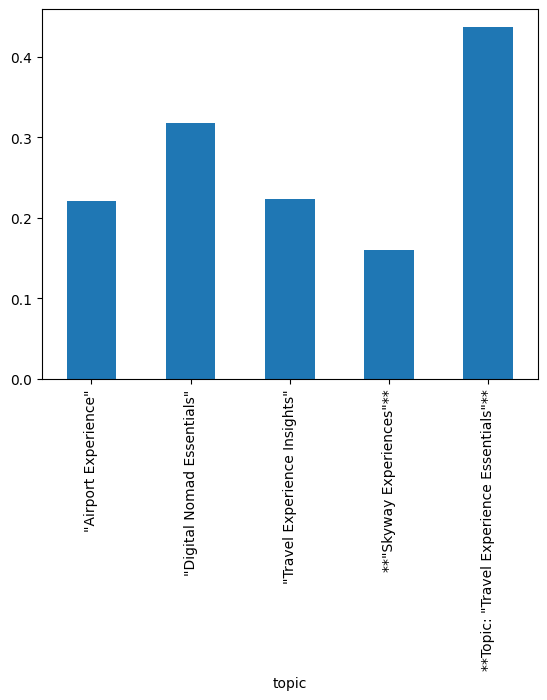

In [13]:
import matplotlib.pyplot as plt
sentiment_summary = test_data.groupby('topic')['sentiment'].mean()
sentiment_summary.plot(kind='bar')
plt.show()

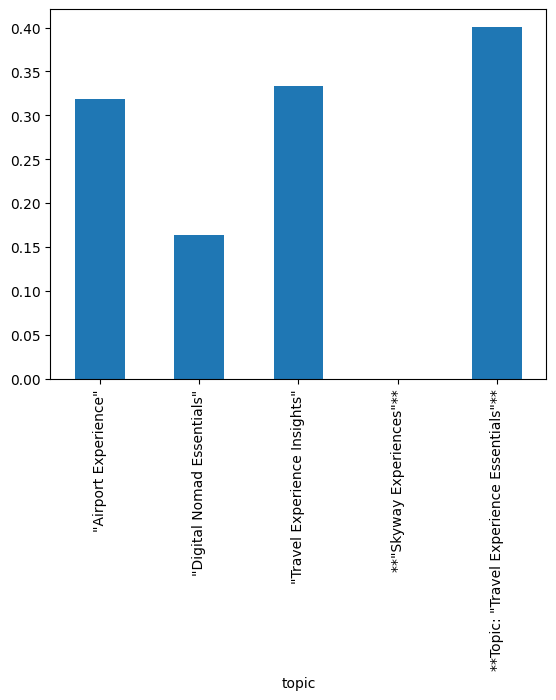

In [14]:
sentiment_summary = test_data.groupby('topic')['sentiment'].median()
sentiment_summary.plot(kind='bar')
plt.show()

## Saving Files

In [15]:
import pickle

with open('../models/lda_model.pkl', 'wb') as f:
    pickle.dump(lda_model, f)

In [16]:
with open('../models/vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [17]:
with open('../data/topic_dict.pkl', 'wb') as f:
    pickle.dump(topic_dict, f)